## Implement a pipeline to cluster points with the help of HRD information

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import copy
import networkx as nx
import itertools

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors, KernelDensity
from scipy.sparse.csgraph import connected_components
from sklearn.mixture import GaussianMixture
#import plotly.graph_objects as go

In [2]:
sys.path.append('../code/')

In [3]:
from Modality.DensityEstKNN import DensityEstKNN
from Modality.kde_modality import KdeModality
from Modality.MergeGraph import MergeGraph
from Modality.merge_strategy import MergePaths
from miscellaneous.utils import pairwise_loop
from NoiseRemoval.RemoveNoiseTransformed import remove_noise_simple
from ScaleSpace.ScaleSpace import ScaleSpaceTree

ModuleNotFoundError: No module named '_diptest'

# Import data

In [6]:
data_dict = {
    'skinny': {
        'path': '/home/sebastian/Documents/PhD/data/skinnydip/skinnyDipData_8.csv',
        'read_csv_kwargs': {},
        'columns2keep': ['V2', 'V3', 'V4'],
        'rename_columns': {'V2': 'f1', 'V3': 'f2', 'V4': 'labels'},
        'astype': {'f1': np.float32, 'f2': np.float32, 'labels': np.int32},
    },
    'adawave': {
        'path': '/home/sebastian/Documents/PhD/data/adawave/waveData_8.csv',
        'read_csv_kwargs': dict(header=None, names=['f1', 'f2', 'labels']),
        'columns2keep': ['f1', 'f2', 'labels'],
        'rename_columns': {},
        'astype': {'f1': np.float32, 'f2': np.float32, 'labels': np.int32}
    }
}

def csv2pandas(data_info):
    X = pd.read_csv(data_info['path'], **data_info['read_csv_kwargs'])
    X = X[data_info['columns2keep']]
    X = X.rename(columns=data_info['rename_columns'])
    X = X.dropna()
    X = X.astype(data_info['astype'])
    return X, data_info['columns2keep']

In [7]:
X, _ = csv2pandas(data_dict['skinny'])
cluster_cols = ['f1', 'f2']
df_cluster = X[cluster_cols]

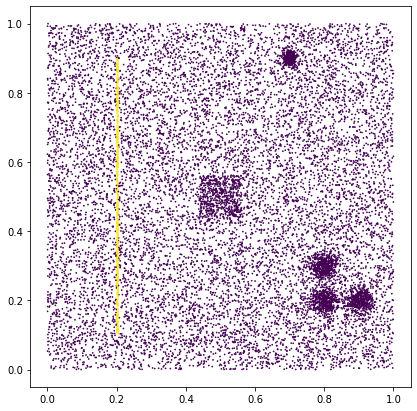

In [8]:
plt.figure(figsize=(7,7))
plt.scatter(X['f1'], X['f2'], c=X['labels']==3, s=0.5)
plt.gca().set_aspect('equal')
plt.show()

# Estimate denstiy

In [9]:
de = DensityEstKNN(df_cluster.values, max_neighbors=200)

# Extract dense components & track them through scale space

In [10]:
data_idx = np.arange(X.shape[0])
sst = ScaleSpaceTree(data_size=X.shape[0], min_jaccard_sim=0.5)

In [11]:
knn_densities_ssp = [30,50,70,90,110,70]

for nb_neighs in knn_densities_ssp:
    kwargs = {'knn_density': nb_neighs, 'knn_neighors_graph': 30, 'alpha': 0.05}

    ## Determine maximum distance
    # Mean distance to the knn_density neighbor -> on average there are knn_density neighbors within a radius of max_dist
    nn = NearestNeighbors(n_jobs=-1).fit(df_cluster.values)
    dist, _ = nn.kneighbors(n_neighbors=kwargs['knn_density'], return_distance=True)
    max_dist = np.median(np.percentile(dist, q=90, axis=1))

    rho = de.knn_density(kwargs['knn_density'])
    #kde = KernelDensity(bandwidth=max_dist/2, atol=1e-6, rtol=1e-5).fit(df_cluster.values)
    #rho = np.exp(kde.score_samples(df_cluster.values)

    # Morse complex/ascending manifold
    mer_gr = MergeGraph(kwargs['knn_neighors_graph'])
    G, lbls, msfull = mer_gr.fit(df_cluster.values, rho)
    
    # Merge paths
    mp = MergePaths(data=df_cluster, graph=G, merge_sequence=msfull, density=rho, labels=lbls, max_dist=max_dist)
    sig_dip, cldict = mp.fit(alpha=kwargs['alpha'])
    fc = mp.flat_clustering()
    print(f'{np.unique(fc).size} cluster found with {nb_neighs} nn density')
    
    # Remove noise
    modes_final = {}
    for uid in np.unique(fc):
        ba = remove_noise_simple(data=df_cluster, cluster_bool_arr=fc==uid, G=G, labels=lbls, density=rho)
        clidx = data_idx[ba]
        mode_idx = clidx[np.argmax(rho[clidx])]
        modes_final[mode_idx] = {'index': clidx, 'boolarr': ba}
    # add partition to the scale space
    part = {key: value['index'] for key, value in modes_final.items()}
    sst.next_scale(partitions=part)

7 cluster found with 30 nn density
6 cluster found with 50 nn density
6 cluster found with 70 nn density
6 cluster found with 90 nn density
4 cluster found with 110 nn density
6 cluster found with 70 nn density


In [12]:
ssp_clusters = sst.scale_space_clusters

In [13]:
G_ssp = nx.Graph()
G_ssp.add_nodes_from(ssp_clusters.keys())
for cli in ssp_clusters.keys():
    for child in ssp_clusters[cli].child_list:
        G_ssp.add_edge(cli, child)

In [14]:
cc_ssp = sorted([list(cc) for cc in nx.connected_components(G_ssp)], key=len)
cc_ssp

[[0],
 [1, 8, 13, 21, 27, 29],
 [33, 2, 9, 17, 19, 26],
 [32, 5, 10, 16, 22, 25],
 [34, 3, 4, 6, 7, 11, 12, 14, 15, 18, 20, 23, 24, 28, 30, 31]]

In [15]:
def sst_positioning(ssp_clusters, cc_ssp):
    positions = {}
    max_x_pos = -1
    for cc in cc_ssp:
        cc = np.sort(cc)
        cluster_levels = np.asarray([ssp_clusters[node].level_id for node in cc])
        for level_i in np.unique(cluster_levels):
            if level_i==0:
                # Add 
                for i, node in enumerate(cc[cluster_levels==level_i]):
                    xpos = max_x_pos + i+1
                    ypos = level_i
                    positions[node] = (xpos, ypos)
            else:
                

SyntaxError: unexpected EOF while parsing (<ipython-input-15-98f2d39be320>, line 15)

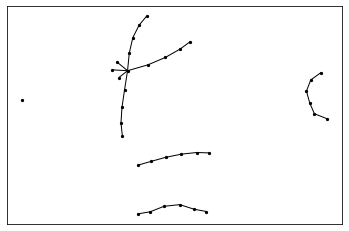

In [17]:
#pos = {n:p for n, p in zip(list(G.nodes), X[['f1','f2']].iloc[list(G.nodes)].values)}
nx.draw_networkx(G_ssp, node_size=5, node_color='k', font_size=0) #, ax=plt.gca())

In [204]:
import random

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a nodeimport random.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                       xcenter = 0.5, rootpos = None, 
                       leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed
        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if parent is not None:
            children.remove(parent)
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G, child, leftmost+leaf_count*leafdx, 
                                                             width=rootdx, leafdx=leafdx,
                                                             vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                                             xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root
                                                            )
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                  leafdx=width*1./leafcount, 
                                                  vert_gap=vert_gap, 
                                                  vert_loc = vert_loc, 
                                                  xcenter = xcenter)
    print(rootpos, leafpos)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

{29: (0.5, 0), 28: (0.5, -0.2), 20: (0.16666666666666666, -0.4), 18: (0.16666666666666666, -0.6000000000000001), 7: (0.16666666666666666, -0.8), 4: (0.16666666666666666, -1.0), 23: (0.5, -0.4), 14: (0.5, -0.6000000000000001), 11: (0.5, -0.8), 6: (0.5, -1.0), 24: (0.8333333333333333, -0.4), 15: (0.8333333333333333, -0.6000000000000001), 12: (0.8333333333333333, -0.8), 3: (0.8333333333333333, -1.0)} {4: (0.0, -1.0), 7: (0.0, -0.8), 18: (0.0, -0.6000000000000001), 20: (0.0, -0.4), 6: (0.3333333333333333, -1.0), 11: (0.3333333333333333, -0.8), 14: (0.3333333333333333, -0.6000000000000001), 23: (0.3333333333333333, -0.4), 3: (0.6666666666666666, -1.0), 12: (0.6666666666666666, -0.8), 15: (0.6666666666666666, -0.6000000000000001), 24: (0.6666666666666666, -0.4), 28: (0.3333333333333333, -0.2), 29: (0.3333333333333333, 0)}


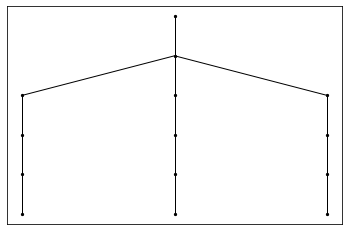

In [212]:
cc = cc_ssp[4]
H = G_ssp.subgraph(cc)
pos = hierarchy_pos(H, root=np.max(cc))
nx.draw_networkx(H, pos=pos, node_size=5, node_color='k', font_size=0) #, ax=plt.gca())

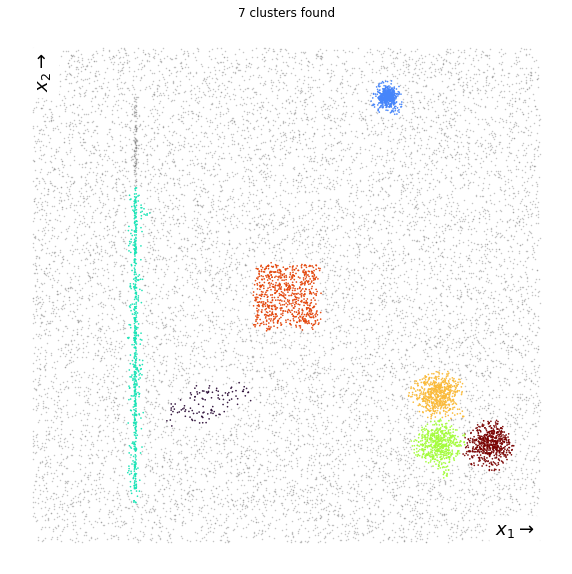

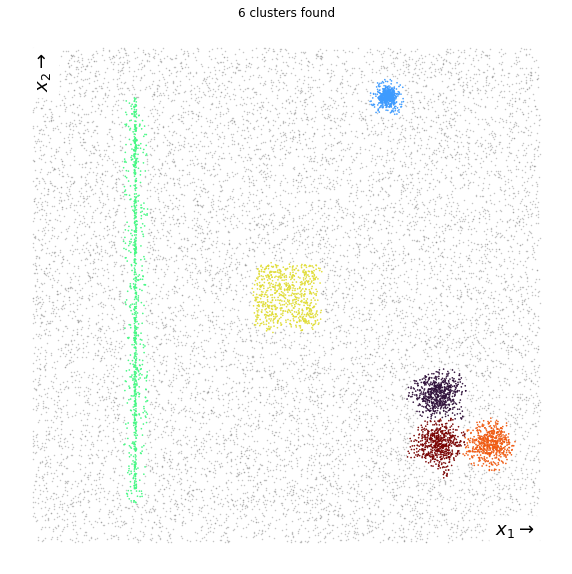

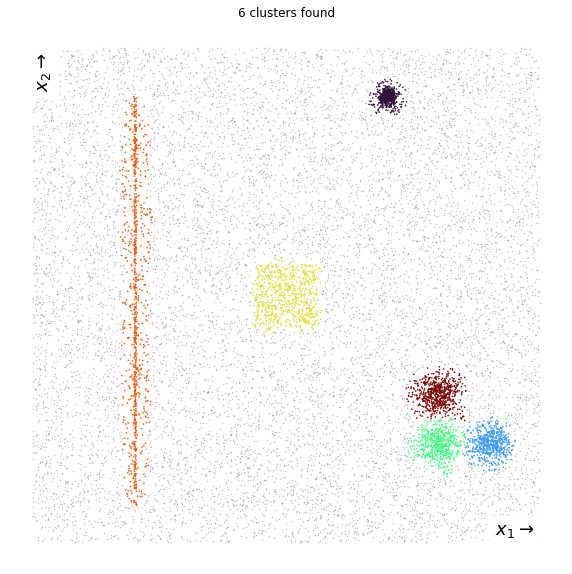

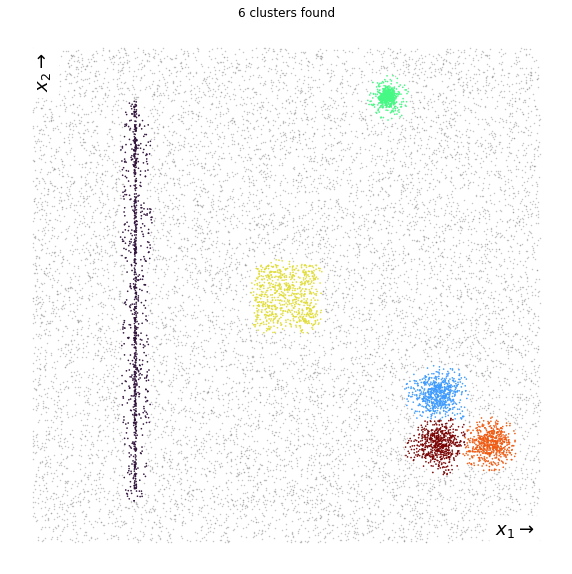

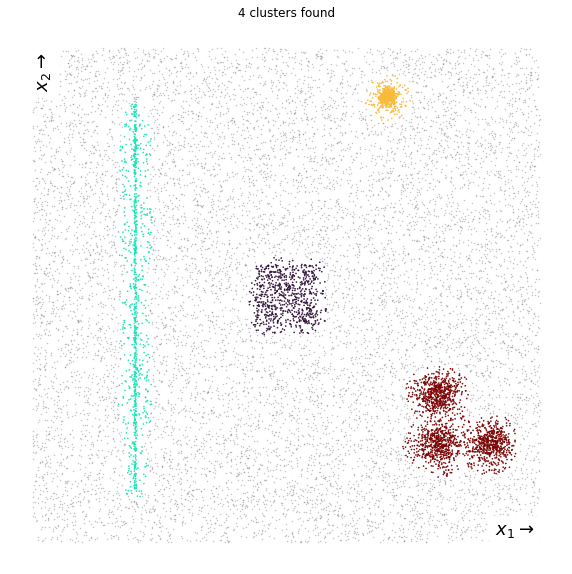

In [119]:
for i in range(len(knn_densities_ssp)):
    fc = sst.labels_from_scale(i)
    
    #for plt_cluster in mp.clusters.values():
    plt.figure(figsize=(10,10))
    colors = ["k","tab:green", "purple", 'tab:blue', 'red', "#e7298a"]
    cmap = ListedColormap(colors)
    plt.scatter(X.loc[fc==-1, 'f1'], X.loc[fc==-1, 'f2'], s=0.2, c='tab:grey', alpha=0.5)
    plt.scatter(X.loc[fc!=-1, 'f1'], X.loc[fc!=-1, 'f2'], s=0.4, c=fc[fc!=-1], cmap='turbo')
    plt.title(f'{np.unique(fc[fc!=-1]).size} clusters found')
    # ------ Style -------
    text_size = 18
    gray_tone = 1
    color_gray = (gray_tone, gray_tone, gray_tone)
    axes_tone_gray = 0
    color_axes = (axes_tone_gray, axes_tone_gray, axes_tone_gray)
    plt.gca().set_facecolor(color_gray)

    xlabel, ylabel = r'$x_1 \rightarrow$', r'$x_2 \rightarrow$'
    plt.annotate(xlabel, xy=(0.945,0.05), xycoords='axes fraction', va='bottom', ha='right', size=text_size, 
                 bbox=dict(boxstyle='round', fc=color_gray, color=color_gray), color=color_axes)
    plt.annotate(ylabel, xy=(0.05, 0.945), xycoords='axes fraction', va='top', ha='left', size=text_size, rotation=90,
                 bbox=dict(boxstyle='round', fc=color_gray, color=color_gray), color=color_axes)
    plt.gca().get_yaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticklabels([]);
    for direction in ['left', 'right', 'top', 'bottom']:
        plt.gca().spines[direction].set_visible(False)

    #plt.savefig(f'/home/sebastian/Desktop/plots/skinny_modes_singleclust.png', bbox_inches='tight');
    plt.show()